# LQR Control of a Quadrotor

In this part, we are going to use a hover state linearization of the quadrotor, like you wrote in the previous lab to allow the quadrotor to hover. First, we are going to import the various classes and functions we need.

In [1]:
from mae345 import plotting, Crazyflie, animate_quad
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import solve_continuous_are
from IPython.display import HTML

## Problem 1

Now, in the cell below, you will fillout the function that will actually solve the LQR problem. That is, given the matrices $\mathbf{A}, \mathbf{B}, \mathbf{Q}, \mathbf{R}$, you should compute the $K$ that minimizes the LQR cost function. You are encouraged to use the function `scipy.linalg.solve_continuous_are` to solve the CARE. Also, we use the convention that the stabilizing control input is given by $\mathbf{u} = \mathbf{K}\mathbf{x}$ (as opposed to $\mathbf{u} = -\mathbf{K}\mathbf{x}$).

In [2]:
def lqr(A: np.ndarray, B: np.ndarray, Q: np.ndarray, R: np.ndarray) -> np.ndarray:    
    P = solve_continuous_are(A, B, Q, R)
    K = -np.linalg.inv(R) @ (B.T @ P)
    return K

## Problem 2

Finally, you will use all the code you have written thus far to actually stabilize your Crazyflie. The following code implements a version of the Crazyflie class from our `mae345` library that uses the linearization and LQR functions you just wrote. This class is useful as it provides simulation and animation functionality to varify your controller is working. It also saves out $\mathbf{K}$ so it can be loaded onto the actual quadrotor for control. You will need to adjust the gains yourself, but we filled in a few for you to get started.

Once you have a set of gains you want to try on the quadrotor, simply navigate to the `~/MAE345` in your terminal and run the command `sudo python3 run_lab1.py`. It will load the feedback matrix corresponding to your LQR controller and run it on the drone. The drone takes off and lands using the Crazyflie's own PID controller, but your LQR controller will stabilize the drone once it is hover a half meter off the ground. The drone beeps when switching controllers. You must submit the following to confirm that you got the drone to hover successfully:
- A video of your drone hovering
- The file `quad_data/quad_traj.npz`
- This notebook file

### LQR Design

The code for this problem is broken into two sections: designing the LQR controller and running the Crazyflie.

The following cell uses the `lqr` function you just wrote in conjunction with our implementation of the linearization function from the previous lab (here as `self.hover_state_linearization()`) to create an instance of the `CrazyflieLQR` class. The details of this process are not important, but this class provides a lot of functionality for designing the LQR controller. It also saves the $\mathbf{K}$ matrix out as `quad_data/lqr_gains.npy`.

In [3]:
class CrazyflieLQR(Crazyflie):
    def __init__(self, Q: np.ndarray, R: np.ndarray, hover_pos: np.ndarray):
        super().__init__()
        self._hover_pos = hover_pos
        self._hover_state = np.concatenate([self._hover_pos, np.zeros(9)])
        A, B =  self.hover_state_linearization()
        self._K = lqr(A, B, Q, R)
        
        print('Using K matrix:')
        print()
        print(self._K)
        
        np.save('quad_data/lqr_gains', self._K)
        
    @property
    def K(self) -> np.ndarray:
        return self._K
    
    def controller(self, state: np.ndarray, t: float) -> np.ndarray:
        return self._K @ (state - self._hover_state) + np.array([self.mass * self.gravity, 0, 0, 0])

# The first argument is the Q matrix, the second is the R matrix
quad = CrazyflieLQR(np.diag([1000, 1000, 2000, 0.001, 0.001, 1, 100, 100, 1, 0.005, 0.005, 1]), 2 * np.diag([1e5, 6e9, 6e9, 1e4]), np.zeros(3))

Using K matrix:

[[-9.49023594e-15  0.00000000e+00 -1.00000000e-01  0.00000000e+00
   3.66452527e-14  0.00000000e+00 -6.05147989e-15  0.00000000e+00
  -7.74919351e-02  0.00000000e+00  7.43912036e-14  0.00000000e+00]
 [ 0.00000000e+00  2.88675135e-04  0.00000000e+00 -7.67668375e-04
   0.00000000e+00  4.67190959e-20  0.00000000e+00  2.31428618e-04
   0.00000000e+00 -1.47624478e-04  0.00000000e+00 -9.79995989e-20]
 [-2.88675135e-04  0.00000000e+00  6.59898425e-15  0.00000000e+00
  -7.65087770e-04  0.00000000e+00 -2.31099920e-04  0.00000000e+00
   2.64004555e-15  0.00000000e+00 -1.46830037e-04  0.00000000e+00]
 [ 0.00000000e+00  1.08947974e-13  0.00000000e+00 -2.09150244e-13
   0.00000000e+00 -7.07106781e-03  0.00000000e+00  7.71878325e-14
   0.00000000e+00 -2.80623982e-14  0.00000000e+00 -7.10074653e-03]]


This next cell simulates the quadrotor flying with a random initial condition for five seconds and plots some of the states. You should see the system stabilize, or your gains will almost certainly not work on the real Crazyflie. Feel free to change the plotted variables.

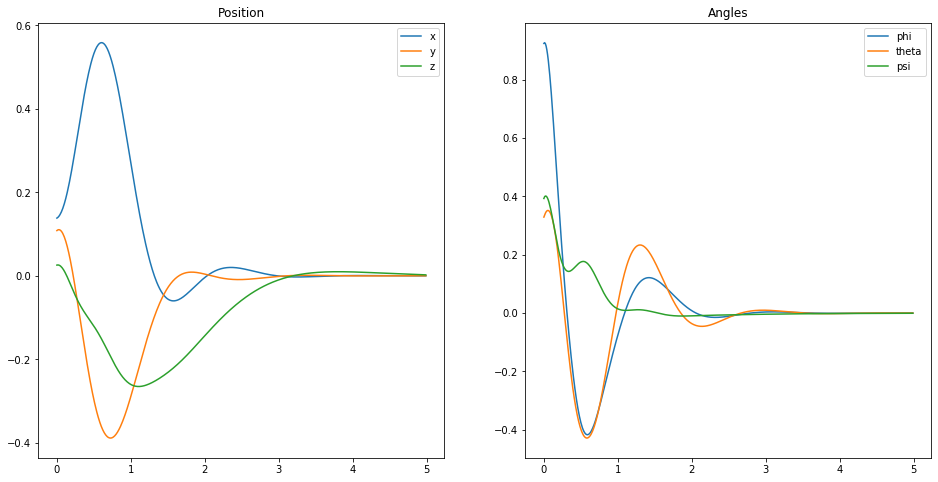

In [4]:
# Uncomment the following line if you want to use the same random initial condition.
# np.random.seed(0)

ic = np.random.rand(12) * 1.2
ic[0:3] = ic[0:3] / 5
ic[6:9] = ic[6:9] / 5

times, states, inputs = quad.simulate(ic, 5, 0.01, clip_input=False)

#%matplotlib notebook
plt.rcParams["figure.figsize"] = (16,8)
fig = plt.figure()

ax = fig.add_subplot(121, title='Position')
ax.plot(times, states[0, :], label='x')
ax.plot(times, states[1, :], label='y')
ax.plot(times, states[2, :], label='z')
ax.legend()

ax = fig.add_subplot(122, title='Angles')
ax.plot(times, states[3, :], label='phi')
ax.plot(times, states[4, :], label='theta')
ax.plot(times, states[5, :], label='psi')
ax.legend()

This cell optionally animates the simulation data computed and plotted in the previous cell.

In [5]:
HTML(animate_quad(0.1, states).to_html5_video())

Finally, this cell plots the result of your physical experiments, i.e. the data logged by the most recent run of `run_lab1.py` in `quad_data/quad_traj.npz`. If you run it before flying the quadrotor, it will error since there is currently no flight data present.

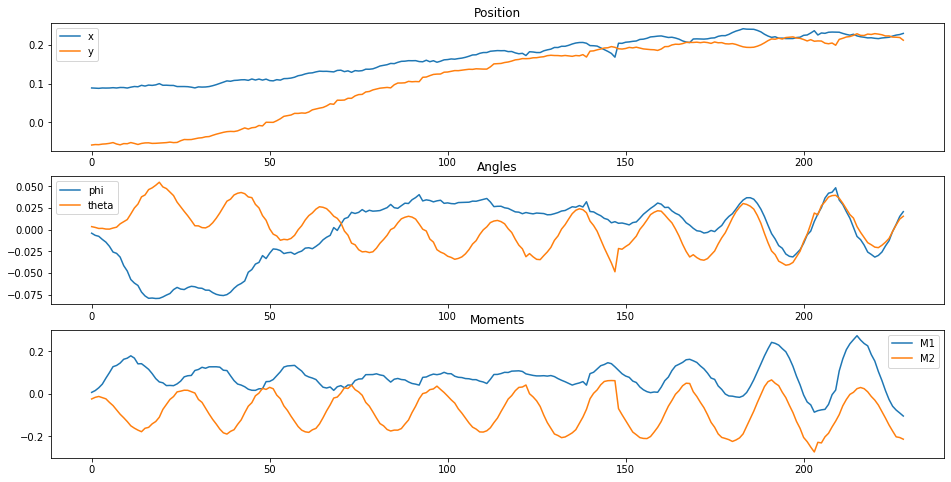

In [26]:
import os

if os.path.isfile('quad_data/quad_traj.npz'):
    npzfile = np.load('quad_data/quad_traj.npz')

    plt.rcParams["figure.figsize"] = (16,8)
    fig = plt.figure()

    ax = fig.add_subplot(311, title='Position')
    ax.plot(npzfile['e_x'], label='x')
    ax.plot(npzfile['e_y'], label='y')
    ax.legend()

    ax = fig.add_subplot(312, title='Angles')
    ax.plot(npzfile['e_roll'], label='phi')
    ax.plot(npzfile['e_pitch'], label='theta')
    ax.legend()

    ax = fig.add_subplot(313, title='Moments')
    ax.plot(npzfile['u2_pwm'] / (2 ** 15), label='M1')
    ax.plot(npzfile['u3_pwm'] / (2 ** 15), label='M2')
    ax.legend()
else:
    print('No flight data found.')

### Running the Quadrotor

#### Setup

Now that you have a set of LQR gains you are happy with trying out, it's time to put them on the quadrotor. First, you need to flash the quadrotor with our modified version of the Crazyflie's firmware. Our modifications apply the LQR control law in real time --- i.e. much faster than we could do with Python over the radio.

**You only need to do this successfully once.** First, hold the power switch down for about 3 seconds until the two blue LEDs flash in sync. Then, open up your terminal and enter the following two commands:

``
cd ~/crazyflie-firmware
make cload
``

Once this is completed, your Crazyflie should restart and play a jingle. If all the lights are on, not flashing, and no jingle plays, repeat the flashing process.

#### Flying

Now change the `group_number` variable to have your group number like last week.

In [6]:
group_number = 80

To test out the quadrotor, simply run the cell below after placing it in the netted area. If you seen an error about something missing in the Log TOC (e.g. `stabilizer.controller not in param TOC`), this most likely means your computer lost connection with the drone midflight.

In [9]:
import logging
import random
import time
import numpy as np

import cflib.crtp
from cflib.crazyflie import Crazyflie
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncLogger import SyncLogger

URI = f'radio://0/{group_number}/2M'

# Only output errors from the logging framework
logging.basicConfig(level=logging.ERROR)

log_keys = ['e_x',
            'e_y',
            'e_roll',
            'e_pitch',
            'u2_pwm',
            'u3_pwm',]

other_log_keys = []

if __name__ == '__main__':
    cflib.crtp.init_drivers(enable_debug_driver=False)

    with SyncCrazyflie(URI, cf=Crazyflie(rw_cache='./cache')) as scf:
        cf = scf.cf

        lg_stab = LogConfig(name='LQR', period_in_ms=10)
        lg_data = {}

        for key in log_keys:
            lg_stab.add_variable('ctrlLQR.' + key, 'float')
            lg_data[key] = []

        for key in other_log_keys:
            lg_stab.add_variable( key, 'float')
            lg_data[key.split('.')[1]] = []

        for i in range(4):
            for j in range(12):
                cf.param.set_value(f'ctrlLQR.k{i + 1}{j + 1}', '{:.10f}'.format(quad.K[i, j]))

        print('Loaded LQR gain matrix.')
        print('Initializing as PID')
        cf.param.set_value('stabilizer.controller', '1')

        cf.param.set_value('kalman.resetEstimation', '1')
        time.sleep(0.1)
        cf.param.set_value('kalman.resetEstimation', '0')
        time.sleep(2)

        print('Reset Kalman filter.')
        print('Taking off!')

        for y in range(10):
            cf.commander.send_hover_setpoint(0, 0, 0, y / 25)
            #cf.commander.send_stop_setpoint()
            time.sleep(0.1)

        for _ in range(50):
            cf.commander.send_hover_setpoint(0, 0, 0, 0.5)
            #cf.commander.send_stop_setpoint()
            time.sleep(0.1)

        print('Switching to LQR!')
        cf.param.set_value('stabilizer.controller', '3')

        with SyncLogger(scf, lg_stab) as logger:
            t_start = time.time()
            entry_count = 0

            for log_entry in logger:
                cf.commander.send_hover_setpoint(0, 0, 0, 0.5)
                for key, value in log_entry[1].items():
                    lg_data[key.split('.')[1]].append(value)

                entry_count += 1

                if time.time() - t_start > 5:
                    break

        print('Saving data...')
        for key in lg_data.keys():
            lg_data[key] = np.array(lg_data[key])

        np.savez('quad_data/quad_traj', **lg_data)

        print('Switching to PID!')
        cf.param.set_value('stabilizer.controller', '1')

        for _ in range(60):
            cf.commander.send_hover_setpoint(0, 0, 0, 0.5)
            time.sleep(0.1)

        for y in range(10):
            cf.commander.send_hover_setpoint(0, 0, 0, (10 - y) / 25)
            time.sleep(0.1)

        for i in range(10):
            cf.commander.send_stop_setpoint()
            time.sleep(0.1)

print('Done!') 

Connecting to radio://0/80/2M
Connected to radio://0/80/2M
Loaded LQR gain matrix.
Initializing as PID
Reset Kalman filter.
Taking off!
Switching to LQR!
Saving data...
Switching to PID!


KeyError: 'stabilizer.controller not in param TOC'